In [115]:
from keras.layers import Input, Dense, GaussianNoise, Lambda, Dropout, concatenate, LSTM, Add, Multiply, Layer
from keras.models import Model, Sequential, load_model
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam, SGD
from keras import backend as K
import numpy as np
import keras
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from keras.utils import plot_model
from datetime import datetime
import matplotlib.pyplot as plt
import tensorflow as tf
import random
from QHAdam import QHAdam

seed_number = 17
tf.set_random_seed(seed_number)
random.seed(seed_number)
np.random.seed(seed_number)

In [116]:
# H = K.random_normal(shape=(1,2), mean=0.0, stddev=1.0) 
H = K.constant([[1, 1]])
print(K.get_value(H))

[[1. 1.]]


In [117]:
SNR1 = 10
SNR2 = 10
SNRs = [SNR1, SNR2]

In [118]:
k = 2
n_channel = 2
M = 2 ** k
k = int(k)
R = k / n_channel
calc_ebno = lambda SNR: 10 ** (SNR / 10)
ebno = [calc_ebno(SNR) for SNR in SNRs]
ebno1 = calc_ebno(SNR1)
ebno2 = calc_ebno(SNR2)

In [119]:
def generate_data(M, N=100000, n_receiver=2):
    label = np.random.randint(M, size=N)

    data = np.zeros((N, M))
    for i in range(N):
        data[i, label[i]] = 1
    np.random.shuffle(data)
    return data

def TransmissionLayer(x, t, k):
    signal = H[t, k] * x

    for i in range(t):
        if i == k:
            continue
        interference = H[i, k] * x
        signal = signal + interference

    noise = K.random_normal(K.shape(signal),
                        mean=0,
                        stddev=np.sqrt( 1/ (2 * R * ebno[k])))
    return signal + noise



In [120]:
# Layer definitions
input_signal1 = Input(shape=(M,), name="input1")
input_signal2 = Input(shape=(M,), name="input2")
encoder1 = Sequential([
    Dense(M, activation="relu"),
    Dense(n_channel, activation="relu"),
    BatchNormalization(center=False, scale=False),
], name="encoder1")
# encoder2 = Sequential([
#     Dense(M, activation="relu"),
#     Dense(n_channel, activation="relu"),
#     BatchNormalization(center=False, scale=False),
# ], name="encoder2")

combiner = Sequential([
    Dense(n_channel, activation="relu"),
    Dense(n_channel, activation="tanh"),
    BatchNormalization(center=False, scale=False),
    # Lambda(lambda x: np.sqrt(n_channel)*K.l2_normalize(x,axis=1), name="normalization")
    # BatchNormalization(),
    # Lambda(lambda x: x / K.sqrt(K.mean(x**2))) #average power constraint
], name="combiner")

transmitted1 = Lambda(TransmissionLayer, arguments={"t":0, "k":0})
transmitted2 = Lambda(TransmissionLayer, arguments={"t":0, "k":1})

signal_input1 = GaussianNoise(np.sqrt(1 / (2 * R * ebno1)))
signal_input2 = GaussianNoise(np.sqrt(1 / (2 * R * ebno2)))

decoder1 = Sequential([
    Dense(M, activation="relu"),
    Dense(M, activation="softmax")
], name="decoder1")
decoder2 = Sequential([
    Dense(M, activation="relu"),
    Dense(M, activation="softmax")
], name="decoder2")

In [121]:
# Computation graph
x1 = encoder1(input_signal1)
x2 = encoder1(input_signal2)
x = concatenate([x1, x2], axis=1)
x = combiner(x)
x1 = signal_input1(x)
x2 = signal_input2(x)
out1 = decoder1(x1)
out2 = decoder2(x2)

In [136]:
train_data_1 = generate_data(M, N=200000)
train_data_2 = generate_data(M, N=200000)

In [141]:
#Single model
x1 = encoder1(input_signal1)
x1 = signal_input1(x1)
out1 = decoder1(x1)
model1 = Model(inputs = input_signal1, outputs = out1)
model1.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
early_stop = EarlyStopping(patience=100, restore_best_weights=True, monitor="loss")
model1.fit(x=train_data_1, y=train_data_1, validation_split=.5, batch_size=10000,
            epochs=2000, callbacks=[
            early_stop,
            ReduceLROnPlateau(monitor="loss", factor=.5, patience=20),
    ])

: 0.9999 - val_loss: 1.5191e-05 - val_acc: 1.0000
Epoch 236/2000
100000/100000 [==============================] - 0s 2us/step - loss: 2.8509e-04 - acc: 0.9999 - val_loss: 1.5191e-05 - val_acc: 1.0000
Epoch 237/2000
100000/100000 [==============================] - 0s 2us/step - loss: 1.8705e-04 - acc: 1.0000 - val_loss: 1.5206e-05 - val_acc: 1.0000
Epoch 238/2000
100000/100000 [==============================] - 0s 2us/step - loss: 2.2641e-04 - acc: 1.0000 - val_loss: 1.5206e-05 - val_acc: 1.0000
Epoch 239/2000
100000/100000 [==============================] - 0s 2us/step - loss: 2.0563e-04 - acc: 1.0000 - val_loss: 1.5221e-05 - val_acc: 1.0000
Epoch 240/2000
100000/100000 [==============================] - 0s 2us/step - loss: 2.0481e-04 - acc: 0.9999 - val_loss: 1.5221e-05 - val_acc: 1.0000
Epoch 241/2000
100000/100000 [==============================] - 0s 2us/step - loss: 2.8569e-04 - acc: 0.9999 - val_loss: 1.5236e-05 - val_acc: 1.0000
Epoch 242/2000
100000/100000 [====================

In [122]:
model = Model(inputs=[input_signal1, input_signal2], outputs=[out1, out2])
model.summary()
alpha = K.variable(.5)
# optim = QHAdam(lr=0.001)
model.compile(optimizer="adam", loss=["categorical_crossentropy", "categorical_crossentropy"],
              loss_weights=[alpha, (1 - alpha)], metrics=["accuracy"])

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input1 (InputLayer)             (None, 4)            0                                            
__________________________________________________________________________________________________
input2 (InputLayer)             (None, 4)            0                                            
__________________________________________________________________________________________________
encoder1 (Sequential)           (None, 2)            34          input1[0][0]                     
                                                                 input2[0][0]                     
__________________________________________________________________________________________________
concatenate_8 (Concatenate)     (None, 4)            0           encoder1[1][0]             

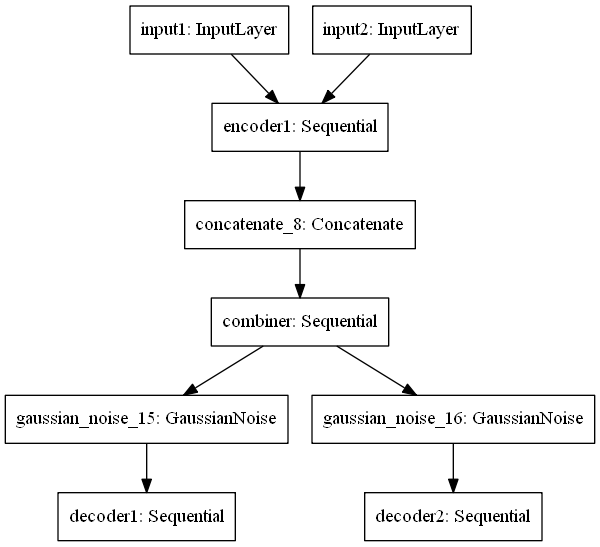

In [123]:
plot_model(model, "hebe.png")

In [124]:
logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=logdir)
early_stop = EarlyStopping(patience=100, restore_best_weights=True, monitor="loss")
# ckpt_callback = ModelCheckpoint(filepath="checkpoints/weights.{epoch:02d}-{val_loss:.2f}.hdf5", monitor="val_loss")
ckpt_callback = ModelCheckpoint(filepath="checkpoints/weights.hdf5", monitor="val_loss")

In [125]:
class AlphaCallback(Callback):
    def __init__(self, alpha):
        super().__init__()
        self.alpha = alpha

    def on_batch_end(self, batch, logs=None):
        loss1, loss2 = logs["decoder1_loss"], logs["decoder2_loss"]
        K.set_value(self.alpha, loss1 / (loss1 + loss2))
        # self.alpha = loss1 / (loss1 + loss2)

In [126]:
train_data_1 = generate_data(M, N=200000)
train_data_2 = generate_data(M, N=200000)

In [127]:
model.fit(x=[train_data_1, train_data_2], y=[train_data_1, train_data_2], validation_split=.5, batch_size=10240,
          epochs=2000, callbacks=[
        tensorboard_callback,
        early_stop,
        # ckpt_callback,
        ReduceLROnPlateau(monitor="loss", factor=.1, patience=20),
        # SGDRScheduler(min_lr=1e-5, max_lr=1e-1, steps_per_epoch=np.ceil(train_data_1.shape[0]/1024)),
        AlphaCallback(alpha)
    ])

oder1_loss: 0.0969 - decoder2_loss: 0.0969 - decoder1_acc: 0.9640 - decoder2_acc: 0.9647 - val_loss: 0.0023 - val_decoder1_loss: 0.0019 - val_decoder2_loss: 0.0027 - val_decoder1_acc: 1.0000 - val_decoder2_acc: 1.0000
Epoch 639/2000
100000/100000 [==============================] - 0s 3us/step - loss: 0.0974 - decoder1_loss: 0.0973 - decoder2_loss: 0.0976 - decoder1_acc: 0.9640 - decoder2_acc: 0.9639 - val_loss: 0.0023 - val_decoder1_loss: 0.0019 - val_decoder2_loss: 0.0027 - val_decoder1_acc: 1.0000 - val_decoder2_acc: 1.0000
Epoch 640/2000
100000/100000 [==============================] - 0s 3us/step - loss: 0.0965 - decoder1_loss: 0.0965 - decoder2_loss: 0.0966 - decoder1_acc: 0.9637 - decoder2_acc: 0.9641 - val_loss: 0.0023 - val_decoder1_loss: 0.0019 - val_decoder2_loss: 0.0027 - val_decoder1_acc: 1.0000 - val_decoder2_acc: 1.0000
Epoch 641/2000
100000/100000 [==============================] - 0s 3us/step - loss: 0.0971 - decoder1_loss: 0.0976 - decoder2_loss: 0.0965 - decoder1_acc:

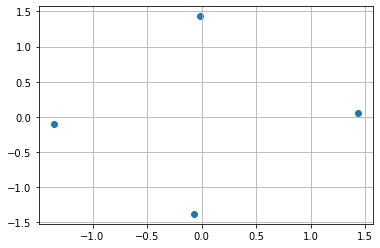

In [142]:
scatter_plot = []
for i in range(M):
    temp = np.zeros(M)
    temp[i] = 1
    out1 = encoder1.predict(np.expand_dims(temp, axis=0))
    scatter_plot.append(out1.squeeze(0))
    # for j in range(M):
    #     temp2 = np.zeros(M)
    #     temp2[j] = 1
    #     out2 = encoder2.predict(np.expand_dims(temp2, axis=0))
    #     out = np.concatenate([out1.squeeze(0), out2.squeeze(0)])
    #     out = combiner.predict(np.expand_dims(out, axis=0))
    #     scatter_plot.append(out.squeeze(0))

scatter_plot = np.array(scatter_plot)

scatter_plot = scatter_plot.reshape(-1, 2, 1)

import matplotlib.pyplot as plt

plt.scatter(scatter_plot[:, 0], scatter_plot[:, 1])
# # plt.axis((-1,1,-1,1))
plt.grid()
plt.savefig('Precoder_{}_{}_Constellation.png'.format(n_channel, k))
plt.show()

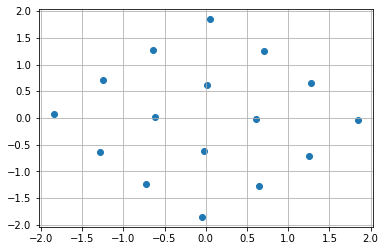

In [132]:
scatter_plot = []
for i in range(M):
    temp = np.zeros(M)
    temp[i] = 1
    out1 = encoder1.predict(np.expand_dims(temp, axis=0))
    for j in range(M):
        temp2 = np.zeros(M)
        temp2[j] = 1
        out2 = encoder1.predict(np.expand_dims(temp2, axis=0))
        out = np.concatenate([out1.squeeze(0), out2.squeeze(0)])
        out = combiner.predict(np.expand_dims(out, axis=0))
        scatter_plot.append(out.squeeze(0))

scatter_plot = np.array(scatter_plot)

scatter_plot = scatter_plot.reshape(-1, 2, 1)

import matplotlib.pyplot as plt

plt.scatter(scatter_plot[:, 0], scatter_plot[:, 1])
# # plt.axis((-1,1,-1,1))
plt.grid()
plt.savefig('Precoder_{}_{}_Constellation.png'.format(n_channel, k))
plt.show()

[0.65879, 0.65325, 0.65009, 0.64534, 0.64551, 0.64502, 0.64543, 0.64463, 0.64581, 0.64774, 0.64844, 0.64801, 0.64666, 0.64418, 0.64006, 0.63866, 0.63429, 0.63076, 0.62911, 0.62621, 0.62498, 0.62406, 0.6238, 0.62339, 0.62335, 0.62339, 0.62337, 0.62337, 0.62338, 0.62338, 0.62338]
[0.80477, 0.80598, 0.81078, 0.80806, 0.81224, 0.81115, 0.80952, 0.80657, 0.80122, 0.79337, 0.78951, 0.78024, 0.77271, 0.76587, 0.75728, 0.74915, 0.7423, 0.73583, 0.7298, 0.7281, 0.72525, 0.72864, 0.73019, 0.73434, 0.73868, 0.74349, 0.74599, 0.74829, 0.74983, 0.75055, 0.75111]


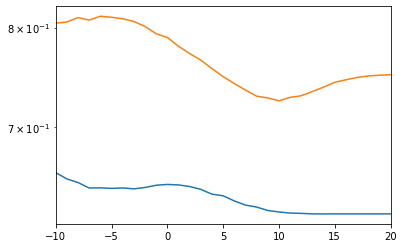

In [130]:
SNR_range = np.arange(0, 31, 1) - 10
ebno_range1 = calc_ebno(SNR_range)
ebno_range2 = calc_ebno(SNR_range)
ber1, ber2 = [], []
test_data_1 = generate_data(M=M)
test_data_2 = generate_data(M=M)
for i in range(len(SNR_range)):
    ebno1 = ebno_range1[i]
    ebno2 = ebno_range2[i]
    out1 = encoder1.predict(test_data_1)
    out2 = encoder2.predict(test_data_2)
    concatenated = np.concatenate([out1, out2], axis=1)
    out = combiner.predict(concatenated)
    noise1 = np.sqrt(1 / (2 * R * ebno1)) * np.random.randn(*out.shape)
    noise2 = np.sqrt(1 / (2 * R * ebno2)) * np.random.randn(*out.shape)
    out1 = decoder1.predict(out + noise1)
    out2 = decoder2.predict(out + noise2)

    pred1 = np.argmax(out1, axis=1)
    pred2 = np.argmax(out2, axis=1)

    errors1 = np.asarray((pred1 != np.argmax(test_data_1, axis=1))).astype(int).mean()
    errors2 = np.asarray((pred2 != np.argmax(test_data_2, axis=1))).astype(int).mean()

    ber1.append(errors1)
    ber2.append(errors2)

print(ber1)
print(ber2)

plt.plot(SNR_range, ber1)
plt.plot(SNR_range, ber2)
plt.yscale("log")
plt.xlim((-10, 20))
plt.savefig('Precoder_{}_{}_BER.png'.format(n_channel, k))
plt.show()

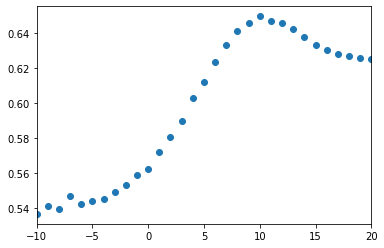

In [133]:
rate_curve = (1 - np.array(ber1)) * R + (1 - np.array(ber2)) * R
plt.scatter(SNR_range, rate_curve)
plt.xlim((-10, 20))
plt.savefig('Precoder_{}_{}_BER.png'.format(n_channel, k))
plt.show()

In [134]:
rate_curve

array([0.53644, 0.54077, 0.53913, 0.5466 , 0.54225, 0.54383, 0.54505,
       0.5488 , 0.55297, 0.55889, 0.56205, 0.57175, 0.58063, 0.58995,
       0.60266, 0.61219, 0.62341, 0.63341, 0.64109, 0.64569, 0.64977,
       0.6473 , 0.64601, 0.64227, 0.63797, 0.63312, 0.63064, 0.62834,
       0.62679, 0.62607, 0.62551])

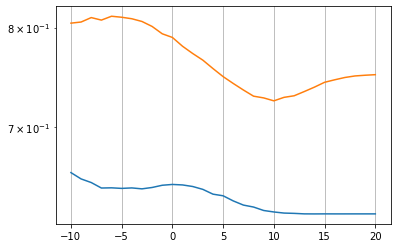

In [135]:
plt.plot(SNR_range, ber1)
plt.plot(SNR_range, ber2)
plt.yscale("log")
# plt.xlim((-10, 20))
plt.savefig('Precoder_{}_{}_BER.png'.format(n_channel, k))
plt.grid()
plt.show()

31